# Enrichment in DE genes

In [1]:
import functools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

## Functions

### Cached functions

In [2]:
@functools.lru_cache()
def get_wgcna_modules():
    return pd.read_csv("../../_m/modules.csv", index_col=0)


@functools.lru_cache()
def get_degs():
    return set(pd.read_csv('../../../../differential_analysis/'+\
                           'caudate/_m/genes/diffExpr_EAvsAA_FDR05.txt',
                           sep='\t', usecols=[0], index_col=0).index)


@functools.lru_cache()
def get_mhc_genes():
    return set(pd.read_csv('../../../../input/counts/mhc_region_genes/'+\
                           '_m/mhc_genes.csv')['gene_id'])

### Simple functions

In [3]:
def fet(a, b, u):
    # a, b, u are sets
    # u is the universe
    yes_a = u.intersection(a)
    yes_b = u.intersection(b)
    no_a = u - a
    no_b = u - b
    m = [[len(yes_a.intersection(yes_b)), len(no_a.intersection(yes_b)) ], 
         [len(yes_a.intersection(no_b)), len(no_a.intersection(no_b))]]
    return fisher_exact(m)


def enrichment_rows():
    mod = get_wgcna_modules().module.unique()
    u = set(get_wgcna_modules().index) 
    for ii in range(len(mod)): # for each module
        a = set(get_wgcna_modules()[(get_wgcna_modules().module) == mod[ii]].index)
        b = set(get_wgcna_modules()[(get_wgcna_modules().module) == mod[ii]].index) - get_mhc_genes()
        yield (mod[ii],
               len(a),
               *fet(a, get_degs(), u),
               *fet(b, get_degs() - get_mhc_genes(), u),
               )


## Main

### Enrichment

In [4]:
edf = pd.DataFrame.from_records(enrichment_rows(), 
                                 columns=['Module_ID', 'N_Genes', 'DEG_OR', 'DEG_P', 
                                          'DEG_noMHC_OR', 'DEG_noMHC_P'],
                                 index='Module_ID')
edf['DEG_FDR'] = multipletests(edf['DEG_P'], method='fdr_bh')[1]
edf['DEG_noMHC_FDR'] = multipletests(edf['DEG_noMHC_P'], method='fdr_bh')[1]
edf = edf.loc[:, ['N_Genes', 'DEG_OR', 'DEG_P', 'DEG_FDR', 'DEG_noMHC_OR', 'DEG_noMHC_P', 'DEG_noMHC_FDR']]

In [5]:
print(edf[(edf["DEG_FDR"] < 0.05)].shape)
edf[(edf["DEG_FDR"] < 0.05)]

(14, 7)


,N_Genes,DEG_OR,DEG_P,DEG_FDR,DEG_noMHC_OR,DEG_noMHC_P,DEG_noMHC_FDR
Module_ID,,,,,,,
grey,12944,1.440224,3.448904e-19,1.276095e-17,1.464040,9.921223e-21,3.670853e-19
blue,1192,0.720031,6.122328e-04,3.236088e-03,0.718478,6.614695e-04,4.079062e-03
violet,56,2.397301,8.508951e-03,2.862102e-02,2.615486,3.264516e-03,1.207871e-02
turquoise,1761,0.727306,5.599962e-05,6.906620e-04,0.739907,1.472774e-04,1.362316e-03
white,83,0.244237,5.375600e-03,2.209969e-02,0.166649,1.533300e-03,6.303567e-03
yellow,447,1.667279,4.125988e-05,6.906620e-04,1.686123,3.678111e-05,6.804505e-04
skyblue,77,1.999277,1.671890e-02,4.458767e-02,2.021343,1.624403e-02,4.623300e-02
darkmagenta,52,0.000000,1.421483e-03,6.574357e-03,0.000000,1.328575e-03,6.144659e-03
brown,1030,0.700099,5.874883e-04,3.236088e-03,0.709675,9.313964e-04,4.923095e-03


In [6]:
print(edf[(edf["DEG_noMHC_FDR"] < 0.05)].shape)
set(edf[(edf["DEG_FDR"] < 0.05)].index) - set(edf[(edf["DEG_noMHC_FDR"] < 0.05)].index)

(13, 7)


{'sienna3'}

#### sienna3 is enriched in MHC differentially expressed genes

In [7]:
edf.to_csv('wgcna_module_enrichment.csv')

### Plot heatmap

<AxesSubplot:title={'center':'Enrichment/depletion DE genes in WGCNA modules\n(FDR values)'}>

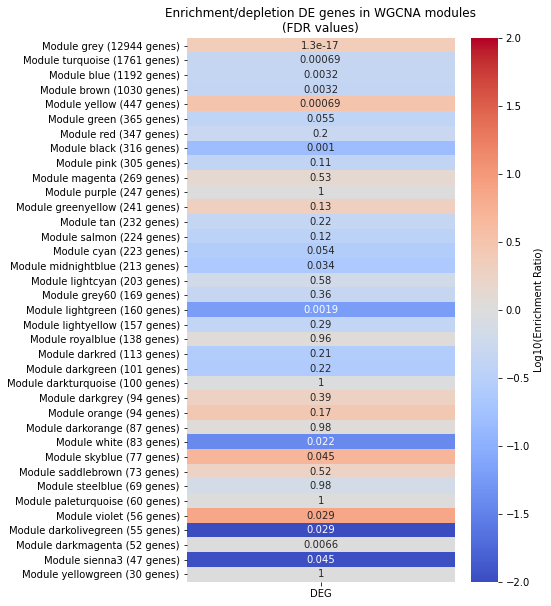

In [8]:
df = edf.sort_values("N_Genes", ascending=False)
df2 = np.log(df.loc[:, ['DEG_OR']]).replace([np.inf, -np.inf], 0)
df2.columns = ['DEG']
df2.index = ["Module %s (%d genes)" % (x,y) for x,y in zip(df2.index, df['N_Genes'])]
df3 = df.loc[:, ['DEG_FDR']]

fig, ax = plt.subplots(figsize=(6,10))
p = sns.heatmap(df2, cmap='coolwarm', annot=df3, yticklabels=df2.index, center=0,
                cbar_kws={'label': 'Log10(Enrichment Ratio)'}, vmin=-2, vmax=2)
p.set_title("Enrichment/depletion DE genes in WGCNA modules\n(FDR values)")
p.get_figure().savefig('wgcna_module_enrichment.pdf', bbox_inches='tight')
p

<AxesSubplot:title={'center':'Enrichment/depletion DE genes in WGCNA modules\n(FDR values)'}>

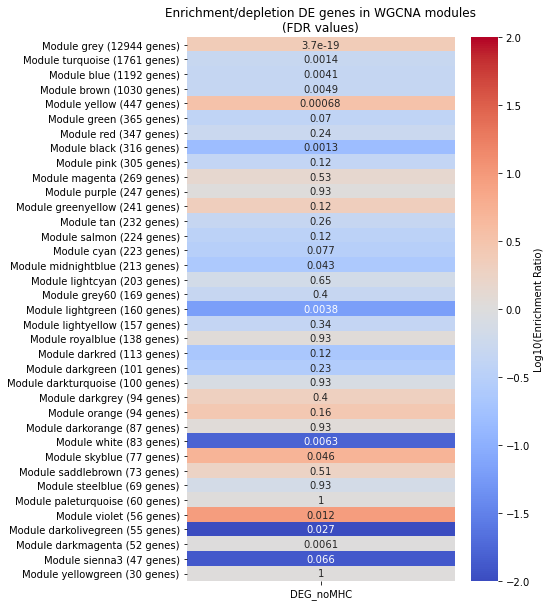

In [9]:
df = edf.sort_values("N_Genes", ascending=False)
df2 = np.log(df.loc[:, ['DEG_noMHC_OR']]).replace([np.inf, -np.inf], 0)
df2.columns = ['DEG_noMHC']
df2.index = ["Module %s (%d genes)" % (x,y) for x,y in zip(df2.index, df['N_Genes'])]
df3 = df.loc[:, ['DEG_noMHC_FDR']]

fig, ax = plt.subplots(figsize=(6,10))
p = sns.heatmap(df2, cmap='coolwarm', annot=df3, yticklabels=df2.index, center=0,
                cbar_kws={'label': 'Log10(Enrichment Ratio)'}, vmin=-2, vmax=2)
p.set_title("Enrichment/depletion DE genes in WGCNA modules\n(FDR values)")
p.get_figure().savefig('wgcna_module_enrichment_noMHC.pdf', bbox_inches='tight')
p